# Homework 4
## Part 1 *(8 points)*
### POS-tagging with Transformers

**Part-of-speech (POS) tagging** is the process of marking up a word in a text as corresponding to a particular part of speech (noun, verb, ...), based on both its definition and its context.


<img src="https://raw.githubusercontent.com/karfly/learning-deep-learning/master/09_transformer/static/pos-tagging.png" width=480>

Let's look at some basic examples:


**Example 1.**

$$\begin{align*}
\text{Input} &= [\text{I love my cat}]\\
\text{Output} &= [\text{PRON VERB PRON NOUN}]
\end{align*}$$


**Example 2.**

$$\begin{align*}
\text{Input} &= [\text{august 11 , 2000}]\\
\text{Output} &= [\text{PROPN NUM PUNCT NUM}]
\end{align*}$$


---
At first glance it seems that the POS-tagging problem can be solved by collecting a dictionary `{word : POS-tag}`. But natural language is very complex and usually a word's part of speech strongly depends on the context, like in the following examples: 


**Example 3.**

$$\begin{align*}
\text{Input} &= [\text{Look , there is a } \textbf{bear}]\\
\text{Output} &= [\text{VERB PUNCT DET VERB DET } \textbf{NOUN}]
\end{align*}$$



**Example 4.**

$$\begin{align*}
\text{Input} &= [\text{I can not } \textbf{bear } \text{it anymore}]\\
\text{Output} &= [\text{PROPN VERB ADV } \textbf{VERB } \text{PROPN ADV}]
\end{align*}$$

In the example 3 the word `bear` is a NOUN, but `bear` in the example 4 is a VERB. This can only be derived from the context. Such examples are not rare, on the contrary, they are very common in human languages (e.g. see [homonyms](https://en.wikipedia.org/wiki/Homonym)). Today we'll tackle this problem by using the most successful (so far) deep learning architecture for NLP – [Transformer](https://arxiv.org/abs/1706.03762)!

### Homework plan

In this homework you'll implement and train a **Transformer** for POS-tagging. The **main goal** of this homework is to get to know with the **Transformer architecture** and to understand how it works from the inside.

### Grading
The main metric in this homework is accuracy calculated on the **test** set (please, don't train on test set – it will be easily revealed by the TAs). Also, you are not allowed to change train/val/test data.

We will grade implementation, training and evaluation of your Transformer model. The test accuracy must be **> 85%**.

Sorry, there are no strict grading criteria, it's very hard to come up with them. We'll rely on common sense.

### Tips
- Do not start writing code before you have read and understood the theory.
- Read all the text in this notebook (hope, you're reading this).
 
### Disclaimer
ConvNets can be better than Transformers in POS-tagging task in the case of small data. In this homework you'll train models on a very small dataset (12 543 train sentences) which is ridiculous on the scale of modern NLP datasets (millions or even billions of sentences!). Anyway, it's very important to understand how Transformers work and to be ready to apply them in a real-world problem with a large dataset, where Transformers outperform other architectures (Conv, RNN, ...) by a large margin.

**Good luck and have fun!**

In [ ]:
import os
import random

import numpy as np

import torch
from torch import nn

import torchtext
import torchtext.datasets
import torchtext.data

In [ ]:
device = 'cuda'
assert torch.cuda.is_available()

BATCH_SIZE = 128
MAX_LENGTH = 200  # maximum length of the input sentence
MIN_TOKEN_FREQUENCY = 10  # minimum occurrence frequency

In [ ]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Load and prepare data

In this homework you'll use `UDPOS` dataset for POS-tagging. In fact, `UDPOS` dataset is just a collection of pairs `(sequence of words : sequence of corresponding POS-tags)`.


For easy access to the dataset, use [torchtext](https://pytorch.org/text/) library. At first glance, [torchtext](https://pytorch.org/text/)'s interfaces look very strange, but after multiple uses you get used to it, and it appears to be a very nice library.

**Note**: `torchtext.legacy.*` is obsolete (hence the name) and is here just for the educational purpose; it will be removed in the next edition of this homework. Don't use it in real projects.

Let's define `fields` ([torchtext](https://pytorch.org/text/) abstraction) for text and POS-tags:

In [ ]:
TEXT = torchtext.legacy.data.Field(
    batch_first=True,
    lower=True,  # make lowercase
    init_token='<bos>', eos_token='<eos>'  # special tokens: beginning/end of sequence
)

POSTAG = torchtext.legacy.data.Field(
    batch_first=True,
    init_token='<bos>', eos_token='<eos>'
)

Now let's get train/val/test data using defined fields:

In [ ]:
train_data, val_data, test_data = torchtext.legacy.datasets.UDPOS.splits(
    fields=(('text', TEXT), ('postag', POSTAG))
)

print(f"Train size: {len(train_data)} sequences")
print(f"Val size: {len(val_data)} sequences")
print(f"Test size: {len(test_data)} sequences")

Train size: 12543 sequences
Val size: 2002 sequences
Test size: 2077 sequences


Then we build the vocabulary (*note:* using only train data) to get the mapping from token to some unique index:

In [ ]:
TEXT.build_vocab(train_data.text, min_freq=MIN_TOKEN_FREQUENCY)  # filter out rarely occured tokens
POSTAG.build_vocab(train_data.postag)

To convert from token to unique index use `.vocab.stoi[...]` method (`.vocab.itos[...]` for inverse mapping). Here we collect unique indices of `padding` special tokens to use them later:

In [ ]:
TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
POSTAG_PAD_IDX = POSTAG.vocab.stoi[POSTAG.pad_token]
print(f"TEXT_PAD_IDX={TEXT_PAD_IDX}, POSTAG_PAD_IDX={POSTAG_PAD_IDX}")

TEXT_PAD_IDX=1, POSTAG_PAD_IDX=1


Get vocabulary sizes:

In [ ]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(POSTAG.vocab)
print(f"Number of unique words: {INPUT_DIM}")
print(f"Number of unique POS-tags: {OUTPUT_DIM}")
print("All POS-tags:", ' '.join(POSTAG.vocab.itos))

Number of unique words: 2139
Number of unique POS-tags: 21
All POS-tags: <unk> <pad> <bos> <eos> NOUN PUNCT VERB PRON ADP DET PROPN ADJ AUX ADV CCONJ PART NUM SCONJ X INTJ SYM


Finally, we define the data iterators that we'll use for training and evaluation:

In [ ]:
train_iterator, val_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (train_data, val_data, test_data), 
     batch_size=BATCH_SIZE,
     device=device
)

Let's grab a batch and look inside:

In [ ]:
batch = next(iter(train_iterator))
text, postag = batch.text, batch.postag

print(f"text.shape = {text.shape} = [batch_size, seq_len]")
print(f"postag.shape = {postag.shape} = [batch_size, seq_len]")
print(f"Datatype is {text.dtype}")

text.shape = torch.Size([128, 50]) = [batch_size, seq_len]
postag.shape = torch.Size([128, 50]) = [batch_size, seq_len]
Datatype is torch.int64


Well, that's all about the data!

## Transformer

In this part you will implement a slightly modified version of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. Actually, you'll only implement the encoder part, because it's enough for POS-tagging task.

It's **highly recommended** to read [the original Transformer paper](https://arxiv.org/abs/1706.03762) or [this nice article](https://jalammar.github.io/illustrated-transformer/) before starting coding.

The Transformer consists of multiple nested modules like a matryoshka (e.g. `Encoder` consists of `EncoderLayer`, which consists of `MultiHeadAttentionLayer` and `PositionwiseFeedforwardLayer`). In this notebook the implementation of modules is ordered in a [top-down](https://en.wikipedia.org/wiki/Top-down_and_bottom-up_design) manner – first the higher-level modules are implemented (e.g. `Encoder`), that use lower-level modules (e.g. `EncoderLayer`), which are not implemented yet. It's **strongly recommended** to read the notebook to the end to be aware of the code structure, before you start implementing the Transformer.

![](https://raw.githubusercontent.com/karfly/learning-deep-learning/master/09_transformer/static/transformer.png)

The Transformer does not use any recurrent relations. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, **attention mechanisms** and normalizations.

As of 2021, Transformers are the dominant architecture in NLP and are used to achieve state-of-the-art results for many tasks and it appears that they will be in the near future. 


*Note:* in this notebook you'll implement a **learned positional encoding** (in the fashion of [BERT](https://arxiv.org/abs/1810.04805)), not the static one from the [original paper](https://arxiv.org/abs/1706.03762).

### Encoder

The Transformer's encoder attempts to *transform* the entire source sentence, $X = (x_1, ... ,x_n)$, into a sequence of context vectors, $Z = (z_1, ... , z_n)$. So, if our input sequence was 5 tokens long we would have $Z = (z_1, z_2, z_3, z_4, z_5)$. Why do we call this a sequence of context vectors and not a sequence of hidden states? A hidden state at time $t$ in an RNN has only seen tokens $x_t$ and all the tokens before it. However, each context vector here has seen all tokens at all positions within the input sequence.

![](https://raw.githubusercontent.com/karfly/learning-deep-learning/master/09_transformer/static/transformer-encoder.png)

First, the tokens are passed through a standard embedding layer. Next, as the model has no recurrence it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a *positional embedding layer*. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence, starting with the first token, the `<bos>` (beginning of sequence) token, in position 0. The position embedding has a "vocabulary" size of `max_length`, which means our model can accept sentences up to `max_length` tokens long.

The original Transformer implementation from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper does not learn positional embeddings. Instead it uses a fixed static embedding. Modern Transformer architectures, like [BERT](https://arxiv.org/abs/1810.04805), use positional embeddings instead, so we'll use them.

Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position within the sequence. ~~However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, `hid_dim`. This (supposedly) reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor.~~ (*crossed out because [it was misleading](https://deeplearnings-3fl6116.slack.com/archives/C01SF4PKJG6/p1620322986136200)*) To train the model reliably, it's important to make sure that (1) these two summands have values of roughly the same scale so that none of them outpowers the other, and that (2) the sum is roughly within the range that your next layer is initialized for (usually around -2 to 2). Dropout is then applied to the combined embeddings.

The combined embeddings are then passed through $N$ *encoder layers* to get $Z$, which is the output and can be used for any downstream task (e.g. POS-tagging).

The mask, `mask`, is simply the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a `<pad>` token and 0 when it is a `<pad>` token. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to `<pad>` tokens, which contain no useful information.

In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 padding_index=None,
                 max_length=128):
        super().__init__()
        
        self.padding_index = padding_index  # if None, don't use masking
        
        # embeddings
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        # encoder layers (implemented below)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout) for _ in range(n_layers)])
        
        # dropout is applied after summing up token and positional embeddings
        self.dropout = nn.Dropout(dropout)
        
        # scale parameter
        self.scale = torch.nn.Parameter(torch.sqrt(torch.tensor(hid_dim, dtype=torch.float32)), requires_grad=False)
        
        # custom weight initialization
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if hasattr(m, 'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data)
        
    def forward(self, x):
        """
        x (batch of token indices): torch.long tensor of shape [bs, seq_len]
        
        returns (encoded sequence): torch.float32 tensor of shape [bs, seq_len, output_dim]
        """
        device = x.device
        bs, seq_len = x.shape[:2]

        # compute non-padding mask (use self.padding_index)
        mask = None
        if self.padding_index is not None:
            # mask = ## your code here
            mask = 1 * (x != self.padding_index)
        
        # get token embeddings and scale with self.scale parameter
        ## your code here
        token_embeds = self.tok_embedding(x) * self.scale

        # generate input [0, 1, ..., seq_len - 1] for positional embedder [bs, seq_len]
        ## your code here
        # input_pos_embed = torch.arange(0, seq_len, dtype=torch.int, device=device, requires_grad=False)
        input_pos_embed = torch.arange(0, seq_len, device=device)
        
        # get pos embeddings
        ## your code here
        pos_embeds = self.pos_embedding(input_pos_embed)
        
        # sum up token and positional embeddings
        ## your code here
        x = token_embeds + pos_embeds
        
        # apply dropout
        ## your code here
        x = self.dropout(x)

        # apply encoder layers one by one; input shape is [bs, seq_len, hid dim]
        ## your code here
        for layer in self.layers:
            x = layer(x, mask)

        return x

### Encoder Layer

The encoder layers are where all of the "meat" of the encoder is contained.

![](https://raw.githubusercontent.com/karfly/learning-deep-learning/master/09_transformer/static/transformer-encoder-layer.png)

The encoder layer consists of 2 main blocks:
1. Pass the source sentence and its mask into the *multi-head attention layer*, perform dropout on it, add a residual connection and pass it through a [Layer Normalization](https://arxiv.org/abs/1607.06450) layer.
2. Pass the output of the 1st block through a *position-wise feedforward* layer and then, again, apply dropout, a residual connection and then layer normalization to get the output of this layer which is fed into the next layer (the parameters are not shared between layers)


The multi-head attention layer is used by the encoder layer to attend to the source sentence, i.e. it is calculating and applying attention over itself instead of another sequence, hence we call it *self attention*.

[This article](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) goes into more detail about layer normalization, but the gist is that it normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout):
        super().__init__()
        
        # self-attention layer normalization
        self.attention_layer_norm = nn.LayerNorm(hid_dim)
        
        # positionwise feedforward layer normalization
        self.pf_layer_norm = nn.LayerNorm(hid_dim)
        
        # attention layer (implemented below)
        self.attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        
        # positionwise feedforward layer (implemented below)
        self.pf = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        # dropout is applied to the outputs of the attention and positionwise feedforward layers
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        x (sequence of vectors): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        mask (mask of valid elements): torch.bool tensor of shape [bs, seq_len]
        
        returns (processed sequence of vectors): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        """
        ### block 1
        # calculate self-attention + dropout
        ## your code here
        attention = self.attention(x, x, x, mask=mask)
        attention = self.dropout(attention)
        
        # residual (attention) + attention layer norm
        ## your code here
        attention_out = self.attention_layer_norm(attention + x)
        
        ### block 2
        # calculate positionwise feedforward + dropout
        ## your code here
        feedforward = self.pf(attention_out)
        feedforward = self.dropout(feedforward)
        
        # residual (positionwise feedforward) + positionwise feedforward layer norm
        ## your code here
        out = self.pf_layer_norm(feedforward + attention_out)
        
        # return x
        return out

### Multi-Head Attention Layer

One of the key, novel concepts introduced by the Transformer paper is the *multi-head attention layer*. 

![](https://raw.githubusercontent.com/karfly/learning-deep-learning/master/09_transformer/static/transformer-attention.png)

Attention can be thought of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and the key are combined by taking the dot product between them, then applying the softmax operation, scaling by $d_k$ and finally multiplying by the value. $d_k$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

However, the scaled dot-product attention isn't simply applied to the queries, keys and values. Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the scaled dot-product attention is calculated over all heads in parallel. This means instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

The steps in this module are as follows:
1. Calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v` to get `Q`, `K` and `V`.
2. Split the `hid_dim` of the query, key and value into `n_heads` (use `.view`) and correctly permute them so they can be multiplied together.
3. Calculate the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calculated as `hid_dim // n_heads`. Mask the energy not to pay attention over any elements of the sequence we shouldn't.
4. Apply the softmax, dropout and then apply the attention to the value heads, `V`, before combining the `n_heads` together.
5. Finally, multiply the output of step 4 with $W^O$ (represented as `fc_o`). 

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using the `@` operator which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

One thing that looks strange at first is that dropout is applied directly to the attention. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout. This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout):
        super().__init__()
        
        assert hid_dim % n_heads == 0, "hid_dim must be divisible by n_heads"
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        # query, key and value linear networks
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        # output linear networks
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        # dropout is applied to attention
        self.dropout = nn.Dropout(dropout)
        
        # scale parameter
        self.scale = torch.nn.Parameter(torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32)), requires_grad=False)
        
    def forward(self, query, key, value, mask=None):
        """
        query/key/value (batch of queries/keys/values): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        mask (mask of valid elements): torch.bool tensor of shape [bs, seq_len]
        
        returns (multi-head attention): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        """
        
        bs = query.shape[0]
        
        # calculate Q, K, V using corresponding linear networks
        q, k, v = self.fc_q(query), self.fc_k(key), self.fc_v(value)  # shape is [bs, seq_len, hid_dim]
                
        # prepare Q, K, V for the `@` operator
        # shape is [bs, n_heads, seq_len, head_dim]
        ## your code here
        seq_len = query.shape[1]
        Q = q.view(bs, seq_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = k.view(bs, seq_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = v.view(bs, seq_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # compute energy using the `@` operator (don't forget to scale!)
        # shape is [bs, n_heads, seq_len, seq_len]
        # energy = ## your code here  
        energy = (Q @ K.permute(0, 1, 3, 2)) / self.scale 
        
        # apply mask – 1 in mask is a valid element, 0 - not; fill with some large negative numbers (use .masked_fill())
        if mask is not None:
            # energy = ## your code here
            mask_bool = (mask == 0)
            energy = energy.masked_fill(mask=mask_bool.view(mask.shape[0], 1, mask.shape[1], 1), value=-1e30)
        
        # apply softmax along the last dim of energy and get the attention weights + dropout
        # shape is [bs, n_heads, seq_len, seq_len]
        # attention = ## your code here
        attention = torch.nn.functional.softmax(energy, dim=-1)
        attention = self.dropout(attention)
        
        # weight values with calculated attention (use `@` operator)
        # shape is [bs, n_heads, seq_len, head_dim]
        # x = ## your code here
        x = attention @ V

        # squash 1 and 4 dims back
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(bs, -1, self.hid_dim)  # shape is [bs, seq_len, hid_dim]
        
        # apply output linear layer
        # x = ## your code here
        x = self.fc_o(x)
        
        return x

### Position-wise Feedforward Layer

The other main block inside the encoder layer is the *position-wise feedforward layer* This is relatively simple compared to the multi-head attention layer. The input is transformed from `hid_dim` to `pf_dim`, where `pf_dim` is usually a lot larger than `hid_dim`. The original Transformer used a `hid_dim` of 512 and a `pf_dim` of 2048. The ReLU activation function and dropout are applied before it is transformed back into a `hid_dim` representation. 

Why is this used? Unfortunately, it is never explained in the paper.

*The bonus*: we implemented this layer for you!

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        # linear layers
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        # dropout is applied after the first layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        x (sequence of vectors): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        
        returns (processed sequence of vectors): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        """
        # apply linear layers + dropout
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)
        
        return x

## Transformer POS-tagger

Now we have all the parts of the transformer and we can build a Transformer-based POS-tagger. It consists of Transformer encoder and single linear layer, which predicts the classes of POS-tags:

In [ ]:
class TransformerPOSTagger(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hid_dim=64, 
                 n_layers=8, 
                 n_heads=8, 
                 pf_dim=64,
                 dropout=0.1, 
                 padding_index=None,
                 max_length=128):
        super().__init__()
        
        # transformer encoder
        self.encoder = Encoder(
            input_dim,
            hid_dim=hid_dim, 
            n_layers=n_layers, 
            n_heads=n_heads, 
            pf_dim=pf_dim,
            dropout=dropout, 
            padding_index=padding_index,
            max_length=max_length
        )
        
        # linear layer to predict (classify) pos-tags
        self.postag_predictor = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x):
        # apply encoder
        ## your code here
        x = self.encoder(x)
        
        # predict postags
        ## your code here
        x = self.postag_predictor(x)
        
        return x

## Training Pipeline

A common practice in training deep learning models is to a create single-function `run_epoch(...)`, which can be used both for training and evaluation (see `phase` parameter). Here you need to implement forward of the model and the loss calculation. Good news is that you'll reuse this function later for training the Transformer model.

In [ ]:
# If `True`, train the model.
# If `False`, only load weights from "TransformerPOSTagger.pth" and evaluate
DO_TRAIN = True

In [ ]:
def run_epoch(model, dataloader, optimizer, criterion, phase='train'):#...):
    is_train = (phase == 'train')
    if is_train:
        model.train()
    else:
        model.eval()
    
    epoch_loss = 0

    # variables for calculating accuracy
    n_predicted, n_true_predicted = 0, 0
    
    with torch.set_grad_enabled(is_train):
        for i, batch in enumerate(dataloader):
            # unpack batch
            text, postag = batch.text, batch.postag
            
            # make prediction
            ## your code here
            pred = model(text)
            
            # reshape prediction to [-1, output_dim]
            ## your code here
            pred = torch.reshape(pred, (-1, pred.shape[-1]))
            
            # reshape gt labels to [-1, ]
            ## your code here
            gt = torch.reshape(postag, (-1, ))

            # calculate loss
            ## your code here
            loss = criterion(pred, gt)
            
            if is_train:
                # make optimization step
                ## your code here
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                optimizer.step()
                
            # calculate accuracy
            n_true_predicted += ((pred.argmax(-1) == gt) * (gt != POSTAG_PAD_IDX)).sum().item()  # exclude pad token
            n_predicted += torch.sum(gt != POSTAG_PAD_IDX).item()
            
            # log per-batch train metrics   
            epoch_loss += loss.item()

        average_loss = epoch_loss / len(dataloader)
        average_accuracy = n_true_predicted / n_predicted

        # log per-epoch metrics

        return average_loss, average_accuracy

In [ ]:
hid_dim = 64 ## your code here
n_layers = 8 ## your code here
n_heads = 8 ## your code here
pf_dim = 64 ## your code here
dropout = 0.15 ## your code here


model = TransformerPOSTagger(
    INPUT_DIM,
    OUTPUT_DIM,
    hid_dim=hid_dim, 
    n_layers=n_layers, 
    n_heads=n_heads, 
    pf_dim=pf_dim, 
    dropout=dropout, 
    padding_index=TEXT_PAD_IDX,
    max_length=MAX_LENGTH
).to(device)

The learning rate needs to be lower than the default used by Adam, otherwise the learning can be unstable.

Any loss function suitable for classification will also work for us, so we'll choose the obvious standard option – [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) criterion. Make sure to ignore losses calculated over `<pad>` tokens, not to add noise to the total loss (use `ignore_index=`).

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

criterion = nn.CrossEntropyLoss(ignore_index=POSTAG_PAD_IDX) ## ...

if DO_TRAIN:
    optimizer = torch.optim.Adam(model.parameters(), lr=4e-4) ## ...

    best_model_path = './TransformerPOSTagger.pth' ## ...

    print(f"Model has {count_parameters(model)} trainable parameters")

Model has 352789 trainable parameters


Train Transformer POS-tagger:

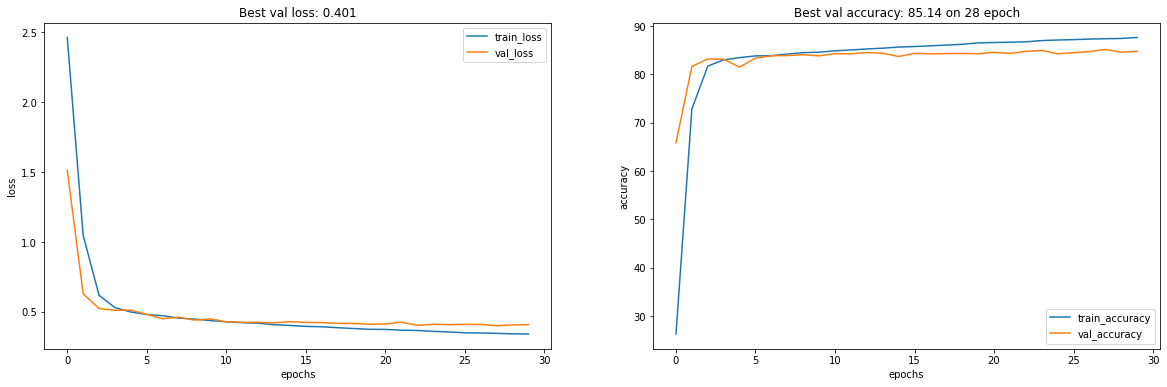

Epoch: 30
	Train Loss: 0.342 | Train accuracy: 87.62
	 Val. Loss: 0.409 |  Val. accuracy: 84.75


In [ ]:
if DO_TRAIN:
    n_epochs = 30 ## your code here

    ####
    import matplotlib.pyplot as plt
    from IPython.display import clear_output

    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []
    best_val_acc = 0
    best_epoch = 0
    ####

    best_val_loss = float('+inf')
    for epoch in range(n_epochs):
        train_loss, train_accuracy = run_epoch(model, train_iterator, optimizer, criterion, phase='train')
        val_loss, val_accuracy = run_epoch(model, val_iterator, None, criterion, phase='val')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

        #####
        
        # save the best validation accuracy and corresponding epoch
        if best_val_acc < val_accuracy:
            best_val_acc = val_accuracy
            best_epoch = epoch

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_accuracy)
        val_acc_history.append(val_accuracy)

        # visualise
        clear_output(wait=True)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
        ax1.plot(train_loss_history, label="train_loss")
        ax1.plot(val_loss_history, label="val_loss")
        ax1.legend()
        ax1.set_xlabel("epochs")
        ax1.set_ylabel("loss")
        ax1.set_title(f'Best val loss: {best_val_loss:.3f}')

        ax2.plot(np.array(train_acc_history) * 100, label="train_accuracy")
        ax2.plot(np.array(val_acc_history) * 100, label="val_accuracy")
        ax2.legend()
        ax2.set_xlabel("epochs")
        ax2.set_ylabel("accuracy")
        ax2.set_title(f'Best val accuracy: {best_val_acc * 100:.2f} on {best_epoch+1:02} epoch')

        plt.show()
        ####

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train accuracy: {train_accuracy * 100:.2f}')
        print(f'\t Val. Loss: {val_loss:.3f} |  Val. accuracy: {val_accuracy * 100:.2f}')

Rename the best model to `TransformerPOSTagger.pth` and upload it to Google Drive, set "Anyone with the link can view". Like in the assignment №2, fill the md5 checksum and the link.

In [ ]:
best_model_md5_checksum = '50b8047b0bccfe1083e851acc5b060b6' # None # ...
best_model_gdrive_link = 'https://drive.google.com/file/d/1okr1ySkxyjIZetOiAEv8W7IrOo0eXsco/view?usp=sharing' # None # ... 

This is how we check your model when grading the assignment.

In [ ]:
if DO_TRAIN:
    model.load_state_dict(torch.load(best_model_path, map_location=device))
else:
    # Download the checkpoint and initialize model weights from it
    import urllib
    import subprocess

    penalize = False

    # Get your link and checksum
    claimed_md5_checksum, google_drive_link = best_model_md5_checksum, best_model_gdrive_link
    
    WEIGHTS_FILE = "./TransformerPOSTagger.pth"

    # Use your link to download "checkpoint.pth"
    !gdown --id {urllib.parse.urlparse(google_drive_link).path.split('/')[-2]}

    try:
        # Compute the actual checksum
        real_md5_checksum = subprocess.check_output(
            ["md5sum", WEIGHTS_FILE]).decode().split()[0]
    except subprocess.CalledProcessError as err:
        # Couldn't download or the filename isn't "TransformerPOSTagger.pth"
        print(f"Wrong link or filename: {err}")
        penalize = True
    else:
        # The trained checkpoint is different from the one submitted
        if real_md5_checksum != claimed_md5_checksum:
            print("Checksums differ! Late submission?")
            penalize = True

    if penalize:
        print("🔫 Prepare the penalizer! 🔫")

    # Finally load weights
    model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))

In [ ]:
test_loss, test_accuracy = run_epoch(model, test_iterator, None, criterion, phase='val')
print(f'Test Loss: {test_loss:.3f} | Test accuracy: {test_accuracy:7.3f}')

Test Loss: 0.413 | Test accuracy:   0.851


Next we'll implement functions to infer our model on any given sentence and display the outputs:

In [ ]:
def infer_model(sentence, model, device):
    model.eval()
    
    # get tokens
    if isinstance(sentence, str):
        tokens = [token.lower() for token in sentence.split(' ')]  # split if string
    else:
        tokens = [token.lower() for token in sentence]
    
    # add <bos> and <eos> special tokens to the beginning and to the end
    ## your code here
    tokens.insert(0, '<bos>') 
    tokens.append('<eos>')
    
    # convert tokens to indices
    indices = [TEXT.vocab.stoi[token] for token in tokens] ## your code here
    indices = torch.LongTensor(indices).unsqueeze(0).to(device)

    # make predictions
    with torch.no_grad():
        pred = model(indices) ## your code here
        
    # extract pos-tags indices from predictions using .argmax(...)
    # pred_postag_indices ## your code here
    pred_postag_indices = pred.argmax(-1)
    
    # convert from indices to pos-tags
    ## your code here
    pred_postags = [POSTAG.vocab.itos[index] for index in pred_postag_indices[0]] 
    
    # cut off <bos> and <eos>
    tokens = tokens[1:-1]
    pred_postags = pred_postags[1:-1]

    return tokens, pred_postags


def print_predictions(tokens, pred_postags, gt_postags=None):
    print("===> Input sentence:", ' '.join(tokens))
    print()
    
    if gt_postags is not None:
        print("Pred. POS-tag\tGT POS-tag\tCorrect?\tToken\n")
        for token, pred_postag, gt_postag in zip(tokens, pred_postags, gt_postags):
            correct = '✔' if pred_postag == gt_postag else '✘'
            print(f"{pred_postag}\t\t{gt_postag}\t\t{correct}\t\t{token}")
    else:
        print("Pred. POS-tag\tToken\n")

        for token, pred_postag in zip(tokens, pred_postags):
            print(f"{pred_postag}\t\t{token}")
    print()

Sentences from the test set:

In [ ]:
example_index = np.random.randint(0, len(test_data.examples))

sentence = test_data.examples[example_index].text
gt_postags = test_data.examples[example_index].postag
tokens, pred_postags = infer_model(sentence, model, device)

print_predictions(tokens, pred_postags, gt_postags)

===> Input sentence: kudos to allentown post office staff

Pred. POS-tag	GT POS-tag	Correct?	Token

VERB		NOUN		✘		kudos
ADP		ADP		✔		to
VERB		PROPN		✘		allentown
VERB		PROPN		✘		post
NOUN		PROPN		✘		office
NOUN		NOUN		✔		staff



Explore how the trained model works on test sentences:

In [ ]:
example_index = np.random.randint(0, len(test_data.examples))

sentence = test_data.examples[example_index].text
gt_postags = test_data.examples[example_index].postag
tokens, pred_postags = infer_model(sentence, model, device)

print_predictions(tokens, pred_postags, gt_postags)

===> Input sentence: swetha

Pred. POS-tag	GT POS-tag	Correct?	Token

PROPN		PROPN		✔		swetha



And on our own sentences:

In [ ]:
sentence = 'I will definitely pass this homework'
print_predictions(*infer_model(sentence, model, device))

sentence = 'Look , there is a bear'
print_predictions(*infer_model(sentence, model, device))

sentence = 'I can not bear it anymore'
print_predictions(*infer_model(sentence, model, device))

===> Input sentence: i will definitely pass this homework

Pred. POS-tag	Token

PRON		i
AUX		will
ADV		definitely
VERB		pass
DET		this
NOUN		homework

===> Input sentence: look , there is a bear

Pred. POS-tag	Token

NOUN		look
PUNCT		,
PRON		there
VERB		is
DET		a
NOUN		bear

===> Input sentence: i can not bear it anymore

Pred. POS-tag	Token

PRON		i
AUX		can
PART		not
VERB		bear
PRON		it
VERB		anymore



## Report

What was the most difficult thing for you in this part?


**To obtain test accuracy > 85 %. I tried different schedulers with different learning rates and different hyperparameters. Some models were trained even more than for 1000 epochs, but the model always got stucked at 83.6-84.1. What helped me eventually is the gradient clipping (using `torch.nn.utils.clip_grad_norm_()`). It helped to obtain 85.3 % on test with default hyperparameters.**

What was your history of experiments with Transformer? What hyperparameters worked best?

**I tried to vary everything: the number of hidden dimensions `hid_dim` (64-128-256-300-336-512), the number of heads `n_heads` (4-5-6-7-8-10-15), the number of layers `n_layers` (4-5-6-7-8-10), the `pf_dim` (`1*hid_dim` - `2*hid_dim` - `3*hid_dim` - `4*hid_dim` - `5*hid_dim`), the `dropout` (0.05 - 0.1 - 0.15 - 0.2). But as it was said, it never helped me to obtain higher results.**


**Finally, I decided to switch back to the default hyperparameters and apply gradient clipping. The model was tending to easily overfit, so I increased dropout to 0.15, and that helped a little bit.**

Please attach screenshots *(tools to do it: Google Drive, GitHub issues, `IPython.display.Image`, imgur...)* of your logging facility with train and validation loss curves.

<img src='https://drive.google.com/uc?export=view&id=1VgkeVZPw6SGUekVdCsdqsaEm1YNNTeXc' width=300px>

**In case it is not displayed: [link to the image (google drive)](https://drive.google.com/file/d/1VgkeVZPw6SGUekVdCsdqsaEm1YNNTeXc/view?usp=sharing)**

## Checks

* Have you managed to train the Transformer model with the test accuracy **> 85.0%**? <font color='green'>YES</font> 


* Does your Trasformer correctly tag `bear` as a `VERB` in sentence **"I can not bear it anymore"**? <font color='green'>YES</font> 


* Have you uploaded your `TransformerPOSTagger.pth` to Google Drive and input the checksum?  <font color='green'>YES</font> 


* Have you made sure that everything runs without errors on "Restart and Run All" with `DO_TRAIN = False` (in particular, the model is downloaded from Drive, the test accuracy is computed)?  <font color='green'>YES</font> 


* Have you made sure that everything runs without errors on "Restart and Run All" with `DO_TRAIN = True`?  <font color='green'>YES</font> 

## Acknowledgements
- Author: Karim Iskakov.
- Big thanks to Ben Trevett for creating the core part of the Transformer code.